# Extract Cycling Behavior

This notebook shows you how to extract daily metrics about cycling behavior from a heat pump's smart meter data. 

### A Few Important Notes:

- Unfortunately, the whole data set including the smart meter data of all heat pumps cannot be shared. However, an example of a single heat pump with 15-minute resolution is provided in the file ```data/01_smart_meter_data/smd_hp.csv```. This data is used throughout this notebook. Please further note that this file also already contains the daily average temperatures as a separate column. 
- The actual routines of extraction are defined in ```src/helper.py```. Here, just the high-level functions are called. 
- The procedure assumes that the smart meter data loaded and processed contains only of the measurements of the heat pump (i.e., the heat pump is measured separately from all other appliances). If this is not the case, you need to apply non-intrusive load monitoring / load disaggregation first to get a load profile, which contains only the energy consumption of the heat pump. In this case, you might want to check out [my other repository](https://github.com/tbrumue/smd-hp-disaggregation). 

### Imports

In [1]:
# general imports 
import pandas as pd 
import numpy as np 
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# add dicrectories of this repo to system path for and then import necessary functions
sys.path.append(os.path.dirname(os.getcwd())+'/src') 

from utils import *
from helper import *


### Load and Visualize Data

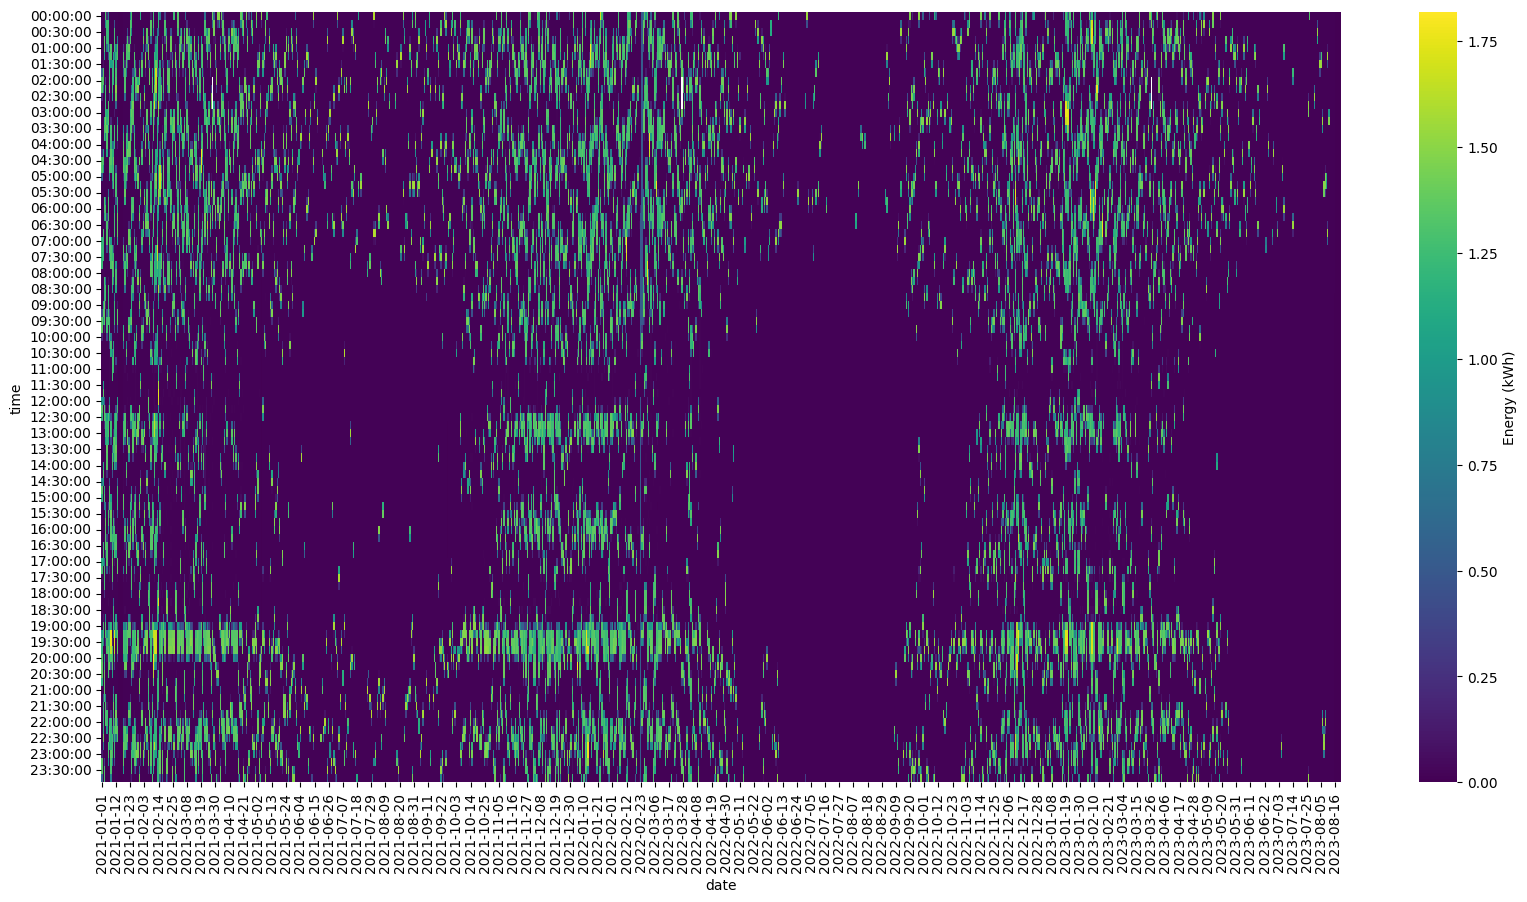

,Timestamp,Energy_kWh,daily_avgTmp
0,2021-01-01 00:00:00,0.013,0.0
1,2021-01-01 00:15:00,0.012,0.0
2,2021-01-01 00:30:00,0.013,0.0
3,2021-01-01 00:45:00,0.013,0.0
4,2021-01-01 01:00:00,0.013,0.0
...,...,...,...
92535,2023-08-20 22:45:00,0.000,24.0
92536,2023-08-20 23:00:00,0.000,24.0
92537,2023-08-20 23:15:00,0.000,24.0
92538,2023-08-20 23:30:00,0.000,24.0


In [2]:
# -------------------------------------------------------------------------
# Column definitions
# -------------------------------------------------------------------------

# define columns for timestamp and consumption
key_timestamp = 'Timestamp' # column identifier of the timestamp in the data frame containing the smart meter data 
key_consumption = 'Energy_kWh' # column identifier of the energy consumption in the data frame containing the smart meter data 
key_temperature = 'daily_avgTmp'  # column identifier of the daily average temperature in the data frame containing the temperature data

# -------------------------------------------------------------------------
# Load smart meter data of a single metering code (heat pump measured separately)
# -------------------------------------------------------------------------

# load smart meter data (CSV example) of a heat pump measured separately
filepath = os.path.dirname(os.getcwd()) + '/data/01_smart_meter_data/smd_hp.csv'
df = pd.read_csv(filepath)

# ensure that the readings are numeric 
df[key_consumption] = pd.to_numeric(df[key_consumption], errors='coerce')

# make the timestamp a datetime object 
df[key_timestamp] = pd.to_datetime(df[key_timestamp])

# visualize as heat map
hm = create_heatmap_data(df.set_index(key_timestamp), column=key_consumption)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(hm, ax=ax, cbar_kws={'label': 'Energy (kWh)'}, cmap='viridis')
plt.show()

display(df)

### Extract Cycling Activity

In [3]:
# -----------------------------------
# CREATE HELPER OBJECT
# -----------------------------------

# create the Helper object for extracting cycles 
helper = CycleHelper(key_timestamp, key_consumption)

# -----------------------------------
# DERIVE LIST OF CYCLES 
# -----------------------------------

# NOTE: if you want to extract an actual list of the cycles, you can must remove the baseload first and then extract the cycles
# estimate baseload and filter out readings below this estimate
df_filtered = helper.filter_out_micro_readings(df)

# double check that filtering worked out - i.e. that more nan values than before - otherwise apply stronger filtering 
if len(df_filtered[df_filtered[key_consumption].isna()]) <= len(df[df[key_consumption].isna()]): 
    df_filtered = helper.filter_out_micro_readings(df, extend_basic_filtering=True)

# extract cycles
df_cycles = helper.extract_cycles(df_filtered, exact_calculation=True, round_decimals=True)

# -----------------------------------
# CALCULATE CYCLING METRICS 
# -----------------------------------

# if you want to calculate the daily cycling metrics, this can be done as follows
df_cycling_metrics = helper.calculate_daily_cycling_metrics(df, parallelized=True, round_decimals=True)

# filter out days without cycling activity
df_cycling_metrics = df_cycling_metrics[(df_cycling_metrics['cycles']>0) & (df_cycling_metrics['operating_hours']>0)]
df_cycling_metrics = df_cycling_metrics.reset_index(drop=True)

# NOTE: now df_cycling_metrics contains the following columns: ['date', 'operating_hours', 'cycles', 'ratio_cycles_operating_hours', 'average_cycle_length_hours', 'energy_sum_kWh']
# NOTE: however 'energy_sum_kWh' corresponds to the filtered energy consumption (i.e. only energy consumption during cycling) 
# instead we want to use the total energy consumption per day (i.e. non-filtered) - therefore drop this column
df_cycling_metrics = df_cycling_metrics.drop(columns=['energy_sum_kWh'])

# ----------------------------------------------------
# ADD DAILY ENERGY CONSUMPTION AND AVERAGE TEMPERATURE
# ----------------------------------------------------

# resample smart meter data to daily resolution top add energy consumption and temperature data 
df_daily_energy = df[[key_timestamp, key_consumption]].resample('D', on=key_timestamp).sum().reset_index()
df_daily_weather = df[[key_timestamp, key_temperature]].resample('D', on=key_timestamp).mean().reset_index().drop(columns=[key_timestamp])
df_daily = pd.concat([df_daily_energy, df_daily_weather], axis=1).rename(columns={key_timestamp:'date'})
df_daily[[col for col in df_daily.columns.values if col != 'date']] = df_daily[[col for col in df_daily.columns.values if col != 'date']].round(2)

# now add temperature and energy consumption to df_cycling_metrics
df_cycling_metrics['date'] = pd.to_datetime(df_cycling_metrics['date'])
df_cycling_metrics = df_cycling_metrics.merge(df_daily, on='date', how='left')

# ----------------------------------------------------
# CALCULATE TEMPERATURE CURVE AND FIT LINEAR REGRESSION
# ----------------------------------------------------

# This part performs the following steps for each metric: 
# - filter and only consider values in the given temperature range 
# - ensure that the minimum number of temperatures at which observations are available is met
# - calculate temperature curves (i.e. median values per outdoor temperature) 
# - fit linear regression to the temperature curves 
# - extract R^2 values, intercept and slope of the fitted linear model

# define settings for linear regression
metrics = ['operating_hours' , 'cycles', 'ratio_cycles_operating_hours', 'average_cycle_length_hours'] # the metrics for which to calculate linear regressions
temp_min = 0 # the minimum temperature to be considered for the temperature curves 
temp_max = 12 # the maximum temperature to be considered for the temperature curves
min_temps = 6 #  minimum number of different temperature values to be observed for linear regression - otherwise regression should not be calculated because it would be erroneous

# calculate linear regression parameters for each metric
df_params = helper.calculate_linear_regression_parameters_from_daily_metrics(df_cycling_metrics, temp_col=key_temperature, metrics=metrics, temp_min=temp_min, temp_max=temp_max, min_temps=min_temps)

# ----------------------------------------------------
# SHOW RESULST
# ----------------------------------------------------

# show what has been extracted 
display(df_cycles)
display(df_cycling_metrics)
display(df_params)

,cycle_number,cycle_start,cycle_end,cycle_duration,cycle_energy_sum
0,0,2021-01-01 01:45:00,2021-01-01 02:30:00,0.64,3.41
1,1,2021-01-01 04:15:00,2021-01-01 05:00:00,0.65,3.45
2,2,2021-01-01 07:00:00,2021-01-01 07:45:00,0.99,4.86
3,3,2021-01-01 09:15:00,2021-01-01 10:00:00,0.61,3.27
4,4,2021-01-01 12:00:00,2021-01-01 12:30:00,0.65,3.5
...,...,...,...,...,...
4394,4394,2023-08-08 21:45:00,2023-08-08 22:15:00,0.42,2.59
4395,4395,2023-08-09 05:00:00,2023-08-09 05:15:00,0.49,2.2
4396,4396,2023-08-10 01:00:00,2023-08-10 01:30:00,0.34,2.15
4397,4397,2023-08-10 06:30:00,2023-08-10 07:00:00,0.39,2.43


,date,operating_hours,cycles,ratio_cycles_operating_hours,average_cycle_length_hours,Energy_kWh,daily_avgTmp
0,2021-01-01,6.93,9,1.30,0.77,37.12,0.0
1,2021-01-02,7.07,9,1.27,0.79,37.25,0.0
2,2021-01-03,7.90,9,1.14,0.88,41.86,0.0
3,2021-01-04,7.58,8,1.06,0.95,39.70,-1.0
4,2021-01-05,8.06,8,0.99,1.01,41.92,-1.0
...,...,...,...,...,...,...,...
833,2023-08-07,1.22,2,1.64,0.61,8.45,12.0
834,2023-08-08,0.99,2,2.02,0.50,7.05,15.0
835,2023-08-09,0.49,1,2.04,0.49,3.36,18.0
836,2023-08-10,0.73,2,2.74,0.36,5.69,19.0


,metric,R2,intercept,slope
0,operating_hours,0.967434,7.194341,-0.448159
1,cycles,0.921381,8.967033,-0.340659
2,ratio_cycles_operating_hours,0.929883,1.163626,0.083819
3,average_cycle_length_hours,0.884017,0.831813,-0.034148


### Visualize Daily Metrics

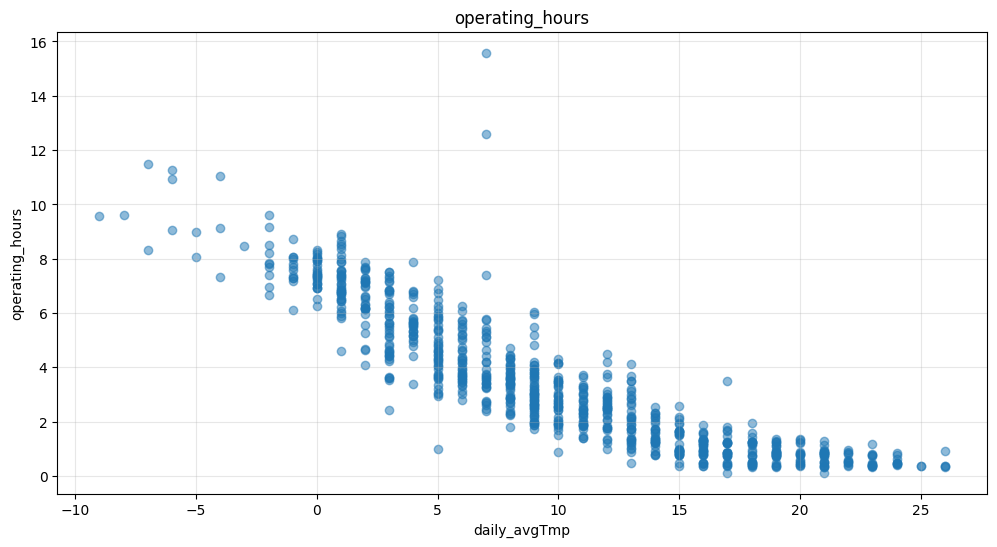

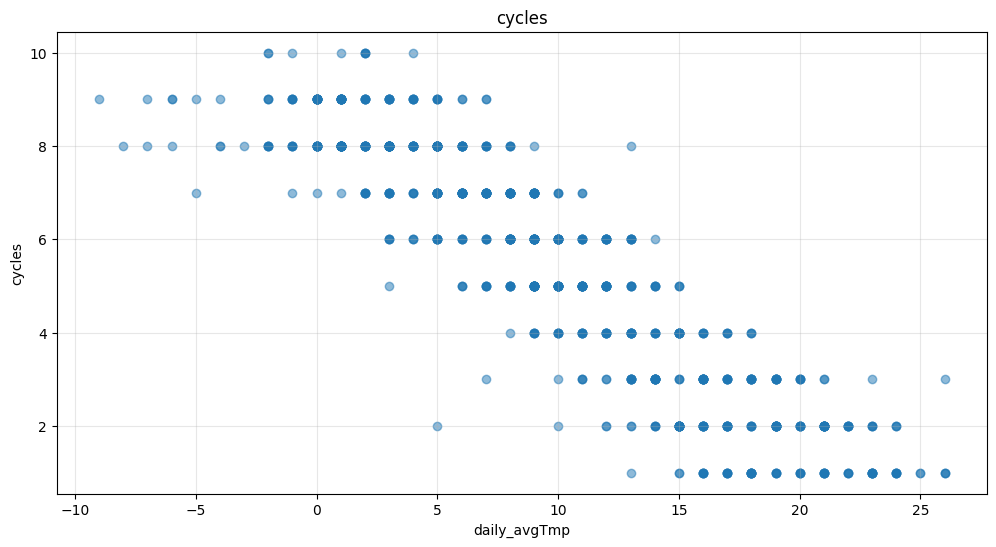

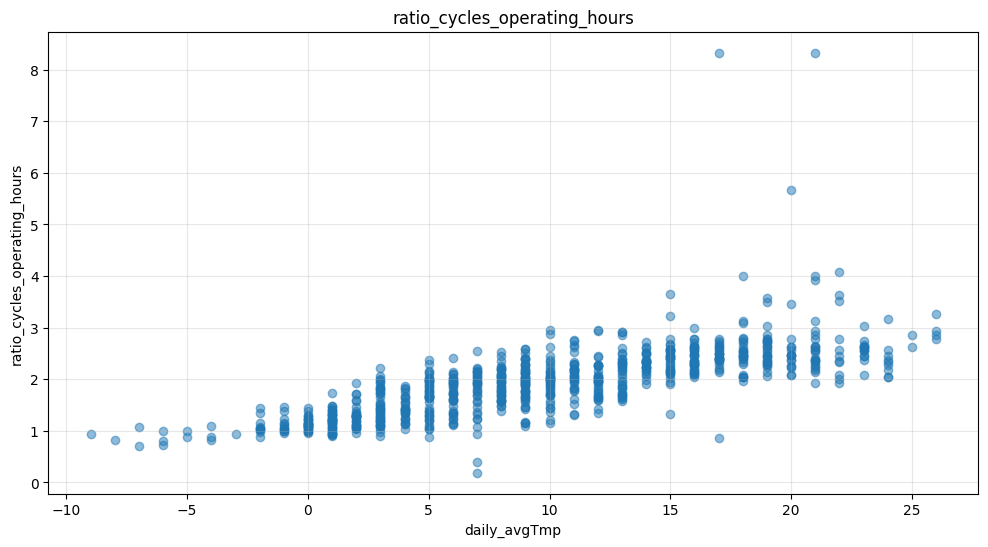

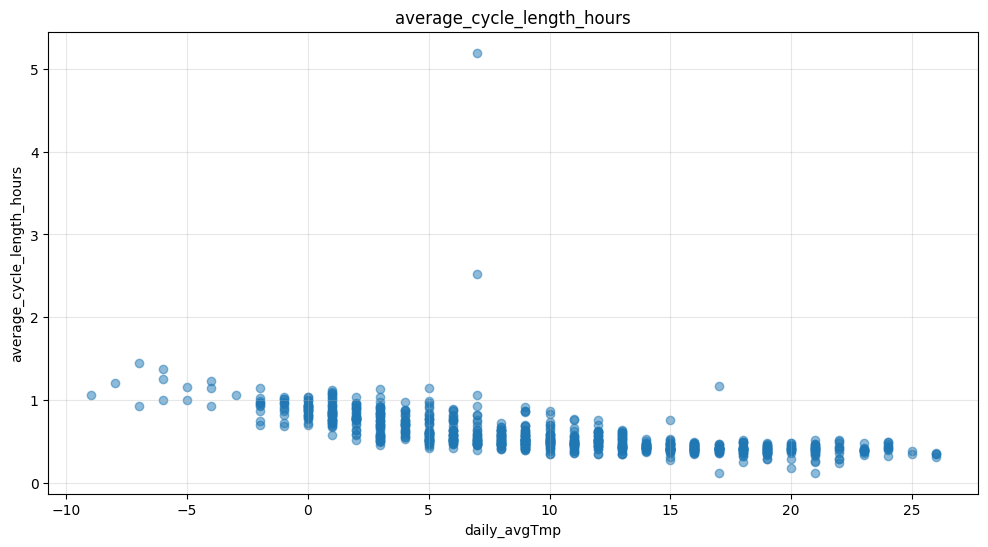

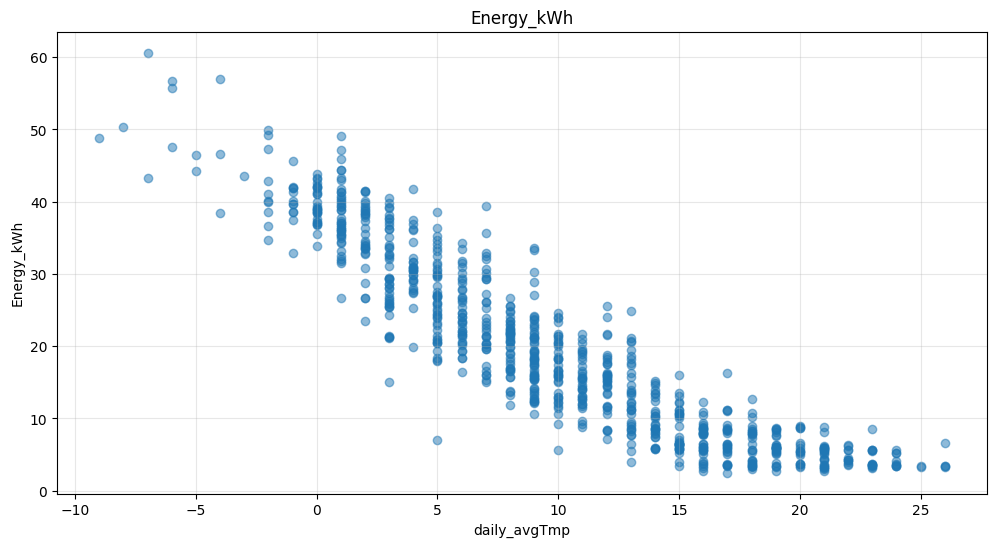

In [4]:
# inspect daily metrics
for col in ['operating_hours', 'cycles', 'ratio_cycles_operating_hours', 'average_cycle_length_hours', key_consumption]:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.scatter(df_cycling_metrics[key_temperature], df_cycling_metrics[col], alpha=0.5)
    ax.set_title(col)
    ax.set_xlabel(key_temperature)
    ax.set_ylabel(col)
    ax.grid(alpha=0.3)
    plt.show()